### This notebook is used to analyze the tracking results generated by the QuPath CEDAR extension.

This notebook is used to check the changes of FTU editing after automatic segmentation and see what FTU types are subject to changes more.

**Note**: The env used for this notebook is monai at MacBook Pro (2023)

### Load the necessary packages

In [13]:
import pandas as pd

### Set up some parameters

In [2]:
working_dir = '/Users/wug/Documents/wgm/work/cedar_nvidia/tracking_analysis/01302025'
src_file = '{}/action_tracking.tsv'.format(working_dir)
print('src_file: {}'.format(src_file))

deletion_output = '{}/deletion_output.tsv'.format(working_dir)  
class_change_output = '{}/class_change_output.tsv'.format(working_dir)

src_file: /Users/wug/Documents/wgm/work/cedar_nvidia/tracking_analysis/01302025/action_tracking.tsv


### Load the tracking results into a DataFrame

In [3]:
tracking_df = pd.read_csv(src_file, sep='\t')
tracking_df.head()

,id,Action,Start Time (ms),End Time (ms),Duration (ms),Property Name,New Property Value,Old Property Value,Time Stamp
0,2,Image Loading,1733867704470,1733867708570,4100,Image File,C:\Users\sevim\Documents\ACED\Batch2\images\00...,NaN,2024-12-10 13:55:04
1,3,Annotation Loading,1733867708570,1733867709856,1286,Annotation File,C:\Users\sevim\Documents\ACED\Batch2\annotatio...,NaN,2024-12-10 13:55:08
2,5,Image Loading,1733867714225,1733867717611,3386,Image File,C:\Users\sevim\Documents\ACED\Batch2\images\02...,NaN,2024-12-10 13:55:14
3,6,Annotation Loading,1733867717612,1733867717709,97,Annotation File,C:\Users\sevim\Documents\ACED\Batch2\annotatio...,NaN,2024-12-10 13:55:17
4,8,Image Loading,1733867739365,1733867742670,3305,Image File,C:\Users\sevim\Documents\ACED\Batch2\images\02...,NaN,2024-12-10 13:55:39


In [4]:
analyzed_actions = tracking_df['Action'].unique()
print('All actions ({}): {}'.format(len(analyzed_actions), analyzed_actions))

# The following actions are used to make changes of FTUs in case they are not correct.
analyzed_actions = [
    'Annotation Editing',
    'Classification Change In Image'
]
print('To be tracked ({}): {}'.format(len(analyzed_actions), analyzed_actions))

All actions (12): ['Image Loading' 'Annotation Loading' 'Annotation Selection in Image'
 'Annotation Deletion' 'Annotation Creation' 'Saving an Annotation'
 'Annotation Structure Editing' 'Annotation Table Selection'
 'Annotation Inference' 'Annotation Moving' 'Annotation Editing'
 'Classification Change in Image']
To be tracked (2): ['Annotation Editing', 'Classification Change In Image']


### Convert the results for each FTU

In [5]:
class FTU_Annotaton_Action:
    def __init__(self, id, action, start_time, end_time, action_id):
        self.id = id
        self.action = action
        self.start_time = start_time
        self.end_time = end_time
        self.action_id = action_id
        self.pre_action_end_time = None
        self.image = None
        self.new_class_value = None
        self.old_class_value = None

In [6]:
# Iterate each row of tracking_df
from collections import defaultdict

action_2_example = {}
for index, row in tracking_df.iterrows():
    action = row['Action']
    if not action in analyzed_actions:
        continue
    action_2_example[action] = row

for action, example in action_2_example.items():
    print('{}\n{}'.format(action, example))
    print()

Annotation Editing
id                                                             62380
Action                                            Annotation Editing
Start Time (ms)                                        1737587931247
End Time (ms)                                          1737587931248
Duration (ms)                                                      1
Property Name         class id: c8f24633-9a7d-45b9-8410-4dd6cfa44940
New Property Value                                                -1
Old Property Value                                                -1
Time Stamp                                       2025-01-22 15:18:51
Name: 61443, dtype: object



In [41]:
def parse_ftu_actions(tracking_df, analyzed_actions):
    id_2_annotation_actions = defaultdict(list)
    id_2_image = {}
    image = None
    for index, row in tracking_df.iterrows():
        action = row['Action']
        if action == 'Image Loading':
            image = row['New Property Value']
        if not action in analyzed_actions:
            continue
        ftuId = None
        if action == 'Annotation Editing':
            tokens = row['Property Name'].split(':')
            property_name = tokens[0].strip()
            if property_name != 'class id':
                continue
            ftuId = tokens[1].strip()
        elif action == 'Classification Change in Image':
            property = row['Property Name']
            if property == 'Classification':
                continue # Old tracking. Ignore it.
            ftuId = row['Property Name'].split(':')[0].strip()
        elif action == 'Annotation Deletion':
            # print('annotation deletion: {}'.format(row))
            property = row['New Property Value']
            tokens = property.split(':')
            ftuId = tokens[0].strip()
            tokens = tokens[1].strip().split(',')
            if tokens[2] != 'auto':
                continue
            # print('annotation deletion: {}'.format(row))
        if not ftuId:
            continue
        actionAnnotation = FTU_Annotaton_Action(ftuId, 
                                                action, 
                                                row['Start Time (ms)'], 
                                                row['End Time (ms)'],
                                                row['id'])
        actionAnnotation.image = image
        if action in ['Annotation Editing', 'Classification Change in Image']:
            actionAnnotation.old_class_value = row['Old Property Value']
            actionAnnotation.new_class_value = row['New Property Value']
        elif action == 'Annotation Deletion': # Use old value to store the class value
            actionAnnotation.old_class_value = row['New Property Value'].split(':')[1].strip().split(',')[0]
        id_2_image[ftuId] = image
        id_2_annotation_actions[ftuId].append(actionAnnotation)

    # Perform a filtered
    auto_ftu_annotation_actions = {id: action_actions for id, action_actions 
                                    in id_2_annotation_actions.items() 
                                    if 'manuel' not in id_2_image[id]}

    print('Total FTUs by editing for auto: {}\n'.format(len(auto_ftu_annotation_actions)))

    count = 0
    for id, action_annotations in auto_ftu_annotation_actions.items():
        print(id)
        for action_annotation in action_annotations:
            print('{},{},{},{},{},{},{},{}'.format(action_annotation.action_id,
                                    action_annotation.action,
                                    action_annotation.start_time,
                                    action_annotation.end_time,
                                    action_annotation.pre_action_end_time,
                                    action_annotation.old_class_value if action_annotation.old_class_value else '',
                                    action_annotation.new_class_value if action_annotation.new_class_value else '',
                                    action_annotation.image))
        print()
        if count == 2:
            break
        count += 1
    return auto_ftu_annotation_actions


In [42]:
auto_ftu_annotation_actions = parse_ftu_actions(tracking_df, analyzed_actions)

Total FTUs by editing for auto: 2291

3ae58656-d1e4-4da1-a5b2-d6528fc3f57e
22,Annotation Deletion,1733867854568,1733867854568,None,15,,C:\Users\sevim\Documents\ACED\Batch2\images\020_1_B_1-2_(3)_5.ome.tif

b7d41209-2121-47d1-8cd1-0fdee1afc57c
39,Annotation Deletion,1733869002133,1733869002133,None,14,,C:\Users\sevim\Documents\ACED\Batch2\images\020_1_B_1-2_(3)_5.ome.tif

4af35321-d6ec-423d-bdea-4c0637f9d4c9
41,Annotation Deletion,1733869003400,1733869003400,None,14,,C:\Users\sevim\Documents\ACED\Batch2\images\020_1_B_1-2_(3)_5.ome.tif



### Load class id to class name mapping

In [15]:
# Load the class id to class name map so that we can analyze based either class id or class name. Right now they are mixed.
class_id_name_file = '../lib/configs/prostate_cancer_path_classes.txt'
# Make sure to use string for the mapping
class_id_name_df = pd.read_csv(class_id_name_file, sep='\t', dtype=str)
# class_id_name_df

# Create mappings
class_id_to_name = dict(zip(class_id_name_df['class_id'], class_id_name_df['class_name']))
class_name_to_id = dict(zip(class_id_name_df['class_name'], class_id_name_df['class_id']))

# Example usage
print(class_id_to_name)
print(class_name_to_id)

{'0': 'unlabeled', '1': 'gleason 3', '2': 'gleason 4 cribriform glands', '3': 'gleason 4 poorly formed glands', '4': 'gleason 4 fused glands', '5': 'gleason 4 glomeruloid glands', '6': 'gleason 5 single cells', '7': 'gleason 5 sheets', '8': 'gleason 5 cords', '9': 'gleason 5 solid nests', '10': 'gleason 5 necrosis', '11': 'prostatic intraepithelial neoplasia', '12': 'benign gland', '13': 'glandular atrophy', '14': 'nerve', '15': 'vein/artery', '16': 'chronic inflammation', '17': 'background stroma', '18': 'not segmented correctly', '19': 'tissue processing artifact'}
{'unlabeled': '0', 'gleason 3': '1', 'gleason 4 cribriform glands': '2', 'gleason 4 poorly formed glands': '3', 'gleason 4 fused glands': '4', 'gleason 4 glomeruloid glands': '5', 'gleason 5 single cells': '6', 'gleason 5 sheets': '7', 'gleason 5 cords': '8', 'gleason 5 solid nests': '9', 'gleason 5 necrosis': '10', 'prostatic intraepithelial neoplasia': '11', 'benign gland': '12', 'glandular atrophy': '13', 'nerve': '14',

### Count the changes

In [28]:
# Create a dataframe for all editing
def get_class_id_name(class_value):
    if class_value in class_id_to_name.keys():
        return class_value, class_id_to_name[class_value]
    elif class_value in class_name_to_id.keys():
        return class_name_to_id[class_value], class_value
    return class_value, class_value # Return the original value if not found


ftu_editing_df = pd.DataFrame(columns=['FTU_id', 'last_action', 'auto_class_id', 'auto_class_name', 'edit_class_id', 'edit_class_name'])
row = 0
for id, action_annotations in auto_ftu_annotation_actions.items():
    old_class_id = None
    old_class_name = None
    new_class_id = None
    new_class_name = None
    last_action = None
    for annotation_action in action_annotations:
        if old_class_id is None:
            old_class_id, old_class_name = get_class_id_name(annotation_action.old_class_value)
        # A FTU can be edited multiple times. We only care about the last edit.
        new_class_id, new_class_name = get_class_id_name(annotation_action.new_class_value)
        last_action = annotation_action.action
    # Escape -1 since it is manually created
    if old_class_id == '-1' or old_class_id is None:
        continue
    if new_class_id == '-1' or new_class_id is None:
        continue # Maybe some tests
    ftu_editing_df.loc[row] = [id, last_action, old_class_id, old_class_name, new_class_id, new_class_name]
    row += 1

ftu_editing_df.to_csv(class_change_output)
print('Write to {}'.format(class_change_output))
print(ftu_editing_df.head(5))

Write to /Users/wug/Documents/wgm/work/cedar_nvidia/tracking_analysis/01302025/class_change_output.tsv
                                 FTU_id         last_action auto_class_id  \
0  ee67bb15-3457-49a9-a5e3-458efe3de160  Annotation Editing            14   
1  f0410dad-106b-4f77-a958-e12023548159  Annotation Editing            11   
2  35684a63-91b4-47c5-b91f-1d3dfd13517b  Annotation Editing            19   
3  79e6e89f-04fa-462f-a27e-751d493b0030  Annotation Editing            19   
4  a060d9e1-8706-4c5c-a21e-157ff23b6c94  Annotation Editing             3   

                       auto_class_name edit_class_id edit_class_name  
0                                nerve             1       gleason 3  
1  prostatic intraepithelial neoplasia            12    benign gland  
2           tissue processing artifact            12    benign gland  
3           tissue processing artifact            12    benign gland  
4       gleason 4 poorly formed glands            12    benign gland  


### Visualize the results

In [29]:
ftu_editing_df.shape

(1364, 6)

In [30]:
# Create transition matrix (counts of changes)
transition_matrix = ftu_editing_df.groupby(["auto_class_name", "edit_class_name"]).size().unstack(fill_value=0)

# Display matrix
transition_matrix


edit_class_name,benign gland,chronic inflammation,glandular atrophy,gleason 3,gleason 4 cribriform glands,gleason 4 fused glands,gleason 4 glomeruloid glands,gleason 4 poorly formed glands,gleason 5 cords,gleason 5 necrosis,gleason 5 sheets,gleason 5 single cells,nerve,prostatic intraepithelial neoplasia,tissue processing artifact,unlabeled,vein/artery
auto_class_name,,,,,,,,,,,,,,,,,
background stroma,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
benign gland,37,0,38,6,0,8,0,314,0,4,2,3,0,15,4,27,11
glandular atrophy,12,0,6,8,0,0,0,0,0,0,0,0,0,0,0,0,1
gleason 3,79,5,35,17,3,11,1,51,0,0,0,0,1,1,8,0,39
gleason 4 cribriform glands,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
gleason 4 fused glands,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
gleason 4 glomeruloid glands,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0
gleason 4 poorly formed glands,8,1,1,11,0,4,0,3,2,5,0,16,0,1,0,0,0
gleason 5 cords,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


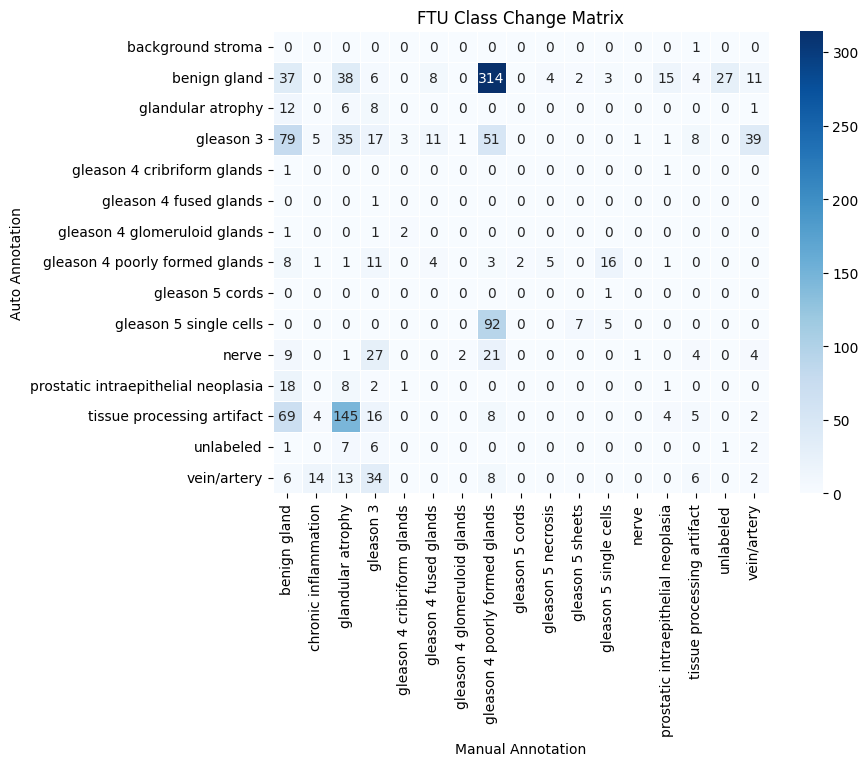

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

# Labels and title
plt.xlabel("Manual Annotation")
plt.ylabel("Auto Annotation")
plt.title("FTU Class Change Matrix")

# Show plot
plt.show()

### Work with deletion

In [43]:
# Parse the deletion actions
analyzed_actions = ['Annotation Deletion']
auto_ftu_deletion_actions = parse_ftu_actions(tracking_df, analyzed_actions)

Total FTUs by editing for auto: 2291

3ae58656-d1e4-4da1-a5b2-d6528fc3f57e
22,Annotation Deletion,1733867854568,1733867854568,None,15,,C:\Users\sevim\Documents\ACED\Batch2\images\020_1_B_1-2_(3)_5.ome.tif

b7d41209-2121-47d1-8cd1-0fdee1afc57c
39,Annotation Deletion,1733869002133,1733869002133,None,14,,C:\Users\sevim\Documents\ACED\Batch2\images\020_1_B_1-2_(3)_5.ome.tif

4af35321-d6ec-423d-bdea-4c0637f9d4c9
41,Annotation Deletion,1733869003400,1733869003400,None,14,,C:\Users\sevim\Documents\ACED\Batch2\images\020_1_B_1-2_(3)_5.ome.tif



In [47]:
ftu_deletion_df = pd.DataFrame(columns=['FTU_id', 'auto_class_id', 'auto_class_name'])
row = 0
for id, action_annotations in auto_ftu_annotation_actions.items():
    for annotation_action in action_annotations:
        if annotation_action.action == 'Annotation Deletion':
            if annotation_action.old_class_value == '-1':
                continue
            auto_class_id, auto_class_name = get_class_id_name(annotation_action.old_class_value)
            ftu_deletion_df.loc[row] = [id, auto_class_id, auto_class_name]
            row += 1

ftu_editing_df.to_csv(deletion_output)
print('Write to {}'.format(deletion_output))
print(ftu_deletion_df.head(5))

                                 FTU_id auto_class_id  \
0  3ae58656-d1e4-4da1-a5b2-d6528fc3f57e            15   
1  b7d41209-2121-47d1-8cd1-0fdee1afc57c            14   
2  4af35321-d6ec-423d-bdea-4c0637f9d4c9            14   
3  bc6931d0-3db5-4315-93c9-4b55fef78d23            19   
4  bda7f801-aaba-4ff9-9fe3-59934db22838            19   

              auto_class_name  
0                 vein/artery  
1                       nerve  
2                       nerve  
3  tissue processing artifact  
4  tissue processing artifact  


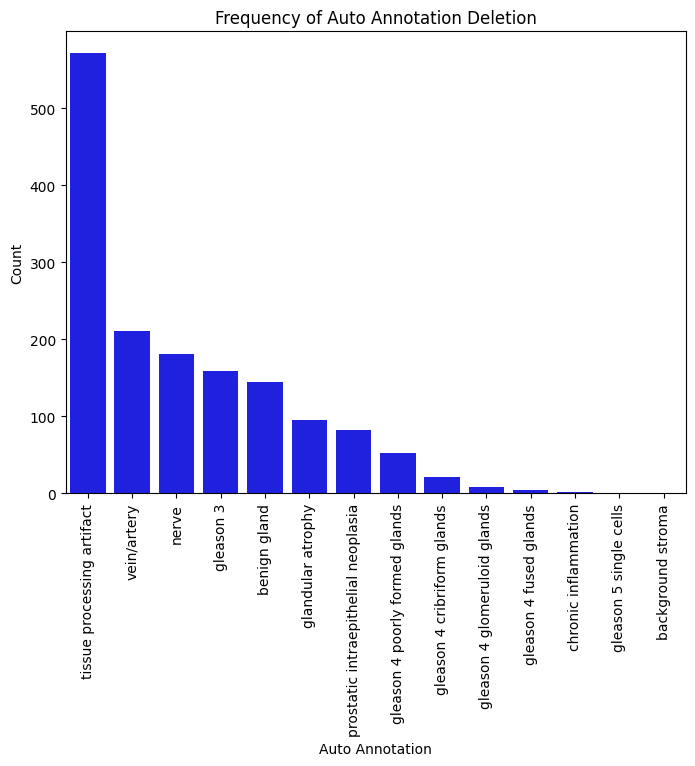

In [49]:
# Count occurrences of each value
value_counts = ftu_deletion_df["auto_class_name"].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, color="blue")

# Labels and title
plt.xlabel("Auto Annotation")
plt.ylabel("Count")
plt.title("Frequency of Auto Annotation Deletion")
plt.xticks(rotation=90)

# Show plot
plt.show()